In [1]:
#import av
import numpy as np
#import trackpy
#import matplotlib #for making plots inside the notebook 
import matplotlib.pyplot as plt #for maknig plots inside the notebook
import skimage
import skvideo.io
from operator import attrgetter
import seaborn as sns
from itertools import chain
from skimage import measure,morphology
from skimage.morphology import diameter_closing
from skimage.filters import *
from glob import glob

"""Currently works on a single frame. Later, will add a loop that can work on all frames."""

'Currently works on a single frame. Later, will add a loop that can work on all frames.'

In [2]:
#filename = input("What is the path to the file?\n")
filename = glob("./tchakamau/Real*half/*5.avi")[0]
tf = 35255
end =12369#30568
print(filename)

./tchakamau\Real_glass_half\45672_15Vpp_5.avi


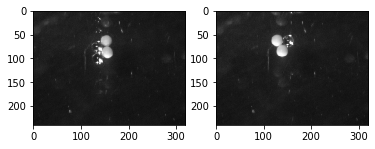

In [3]:
Vid = skvideo.io.vread(filename)

fig, ax = plt.subplots(ncols=2)
ax[0].imshow(Vid[0]) # first fame of video
ax[1].imshow(Vid[-1]) #last frame of video


(56032, 240, 320)


Text(0.5, 1.0, 'Truncated histogram')

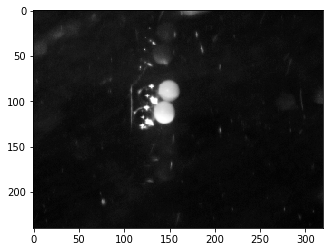

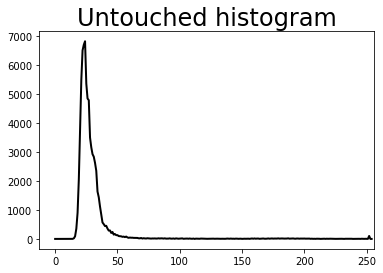

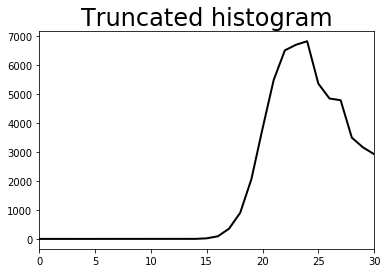

In [4]:
"""Testing that the frames loaded correctly. They should be 2D matrices, in order to be used by sci-kit image programs. 
Shape of the frame colletion should hve 3 values, and shape of each frame should have 2 values.
Checking that a frame is legible as an image by displaying it."""
green = Vid[:, :, :, 2]
print(green.shape)
plt.imshow(green[500], cmap='Greys_r')

# Histogram
fig, ax1 = plt.subplots()
values, bins = np.histogram(green[500],
                            bins=np.arange(256))

ax1.plot(bins[:-1], values, lw=2, c='k')
ax1.set_xlim(xmax=256)
ax1.set_title('Untouched histogram', fontsize=24)


fig, ax1 = plt.subplots()
values, bins = np.histogram(green[500],
                            bins=np.arange(256))

ax1.plot(bins[:-1], values, lw=2, c='k')
ax1.set_xlim(xmax=30, xmin = 0)
ax1.set_title('Truncated histogram', fontsize=24)

In [5]:
"""
First, we'll binarize the whole image for each frame
then find connected components and filter out all but the largest
then, for each frame, see if the largest CC has the right no. of particles (by area sounds good)
if not, then delete that frame from the list

With the resulting list, binarize agian with a diffeent threshold, to eep the transparent one out,
find connected compoents again and take the largest, 
and this time for each frame, see what shape it contains 
    keep a list of frame shapes, 
    including a shape that represents transitioning states, e.g. none-of-the-above.
"""

"\nFirst, we'll binarize the whole image for each frame\nthen find connected components and filter out all but the largest\nthen, for each frame, see if the largest CC has the right no. of particles (by area sounds good)\nif not, then delete that frame from the list\n\nWith the resulting list, binarize agian with a diffeent threshold, to eep the transparent one out,\nfind connected compoents again and take the largest, \nand this time for each frame, see what shape it contains \n    keep a list of frame shapes, \n    including a shape that represents transitioning states, e.g. none-of-the-above.\n"

In [6]:
"""All the work below is done on a single frame 
    Will be applied over all frames eventually"""

'All the work below is done on a single frame \n    Will be applied over all frames eventually'

In [7]:
"""Pt1. 
    Binarize image, 
    and then find conected components
    and then filter those for only the largest
"""

'Pt1. \n    Binarize image, \n    and then find conected components\n    and then filter those for only the largest\n'

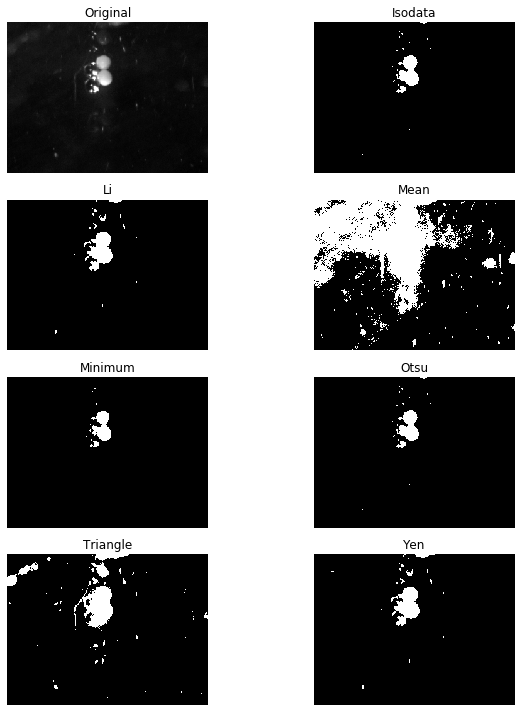

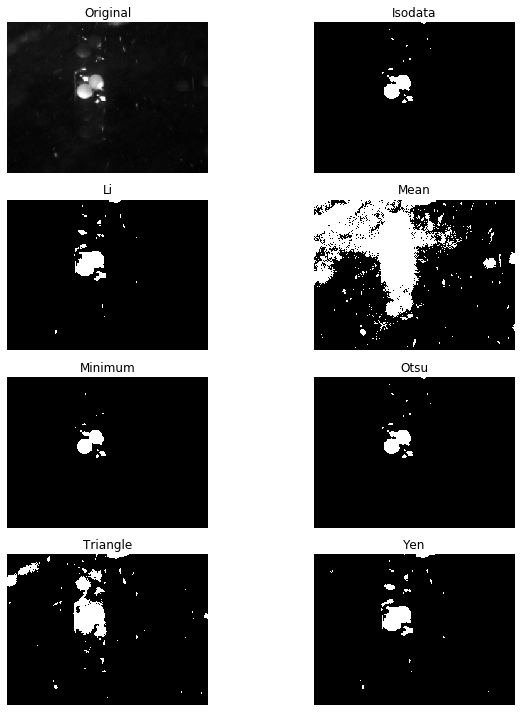

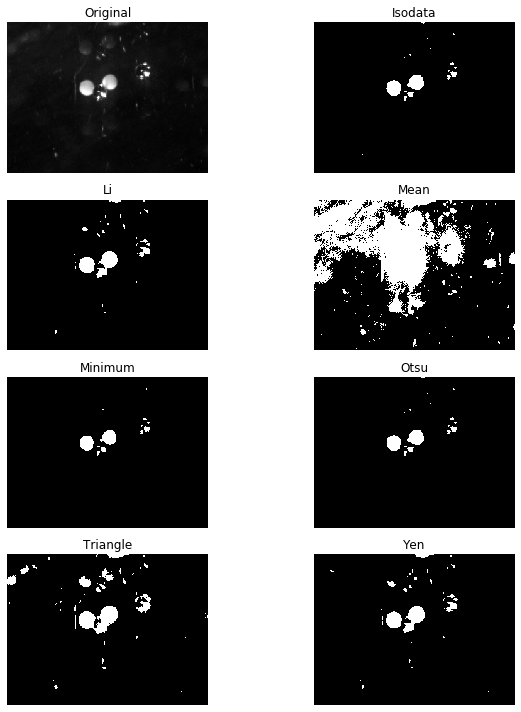

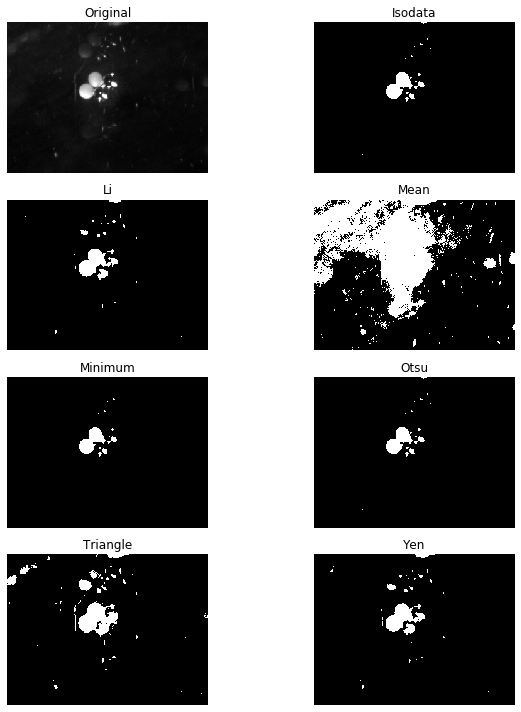

In [8]:
"Tryign built-in thresholds for separating image and background"
from skimage.filters import try_all_threshold
n = 4 # number of times to repeat
for i in range(0, len(green), int(len(green)/n)):
    img = green[i] #example image (tf + 9606 is an error!)

    fig, ax = try_all_threshold(img, figsize=(10, 10), verbose=False)
#plt.show()


In [9]:
"""Pt2. 
    Filter shapes with wrong number of balls 
        Do using area maybe
"""

'Pt2. \n    Filter shapes with wrong number of balls \n        Do using area maybe\n'

"Retreving properties for test frames with 1st hreshold"
"""CHANGED TO LI THRESHOLD!"""
# applies yen filter to test frames, and gets properties
# returns list of the properties
#  fraemelist is a frame and a frame index
def opaque_threshold_properties(framelist):
    filtrate = []
    for framepair in framelist:
        frame = framepair[0]
        thresh_img = frame > threshold_li(frame) # binary image
        thresh_img = morphology.binary_closing(morphology.binary_dilation(thresh_img))
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r = properties_list[0] 
        for region in properties_list:
            if region.area > biggest_r.area:
                biggest_r = region
            else:
                pass
        #img_labelled = measure.label(morphology.dilation(morphology.closing(biggest_r.filled_image)))
        #biggest_r = measure.regionprops(img_labelled, coordinates='rc')[0]
            
        filtrate.append([biggest_r, framepair[1], img_labelled, thresh_img])#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate


i_props = opaque_threshold_properties(unfiltered)
framesets = unfiltered
print(len(framesets))
for i in range(0, len(framesets), int(len(framesets)/25)):
    fig, ax = plt.subplots(ncols=3, figsize=(18, 8))
    ax[0].imshow(unfiltered[i][0])
    ax[1].imshow(i_props[i][2])
    ax[2].imshow(i_props[i][3])

In [10]:
framesets = green
unfiltered = green

"""Broken objects are filtered out by their area and we then move on to identifying odd shaped objects 
    from the remaining frames"""
framesets.remove(broken_frames)
framesetnames.remove("broken")

"Retreving properties for test frames with 2nd threshold"

# applies isodata filter to test frames, and gets properties
# returns list of the properties
def transparent_threshold_properties(framelist):
    filtrate = []
    for framepair in framelist:
        frame = framepair[0] 
        thresh_img = frame > threshold_isodata(frame) # binary image
        img_labelled = measure.label(thresh_img) # contains connected regions
        properties_list = measure.regionprops(img_labelled, coordinates = 'rc') # data about regions, for each connected region
        
        #----------getting maximum connected region----------
        biggest_r_p = properties_list[0] 
        
        for region_props in properties_list:
            region = img_labelled
            if region_props.area > biggest_r_p.area:
                biggest_r_p = region_props
            else:
                pass
            
        filtrate.append([biggest_r_p, framepair[1], img_labelled])#, total_threshed]) # area, frame index in phantom, binary image
    return filtrate

In [11]:
def get_transparent_dot(frame, full, four):
    one_and_some = full^four
    return(one_and_some)
def region_selector(labeled_image, label):
    #print(label)
    x = labeled_image == label
    #plt.imshow(x)
    return x

# make a function that takes a set of labeled regions, and then  returns a boolean array containing only the largest
def largest_region_extractor(labeled_regions_set):
    props_lists = measure.regionprops(labeled_regions_set)
    #print(len(labeled_regions_set), len(props_lists))
    biggest_r_p = props_lists[0]
    biggest_r_label = props_lists[0].label
    for i in range(0, len(props_lists)):
        pli = props_lists[i]
        if pli.area > biggest_r_p.area:
            biggest_r_p = pli
            biggest_r_label = pli.label
        else:
            pass
    return region_selector(labeled_regions_set, biggest_r_label)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


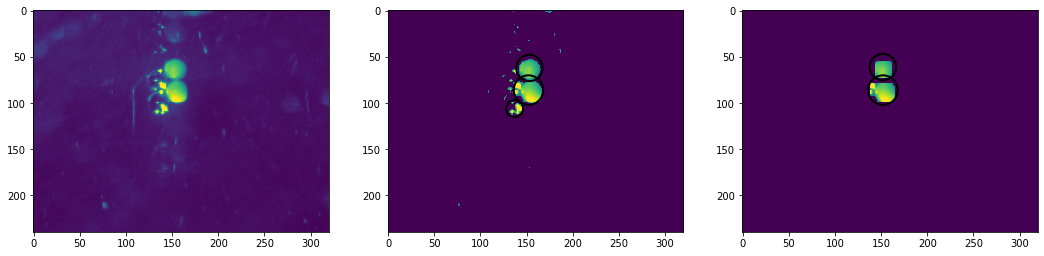

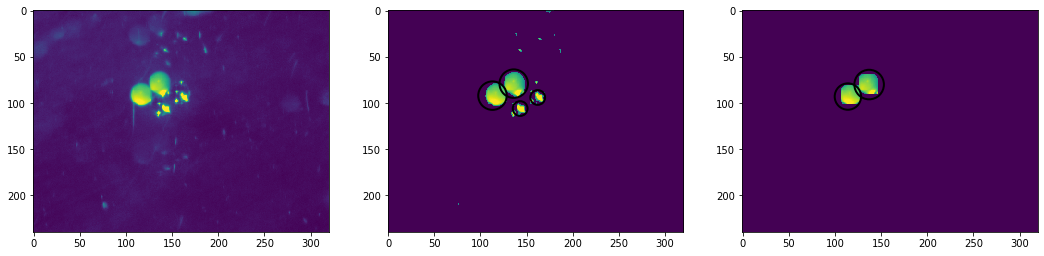

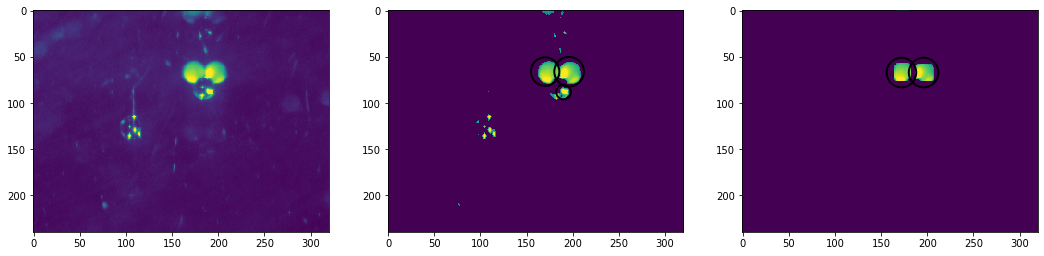

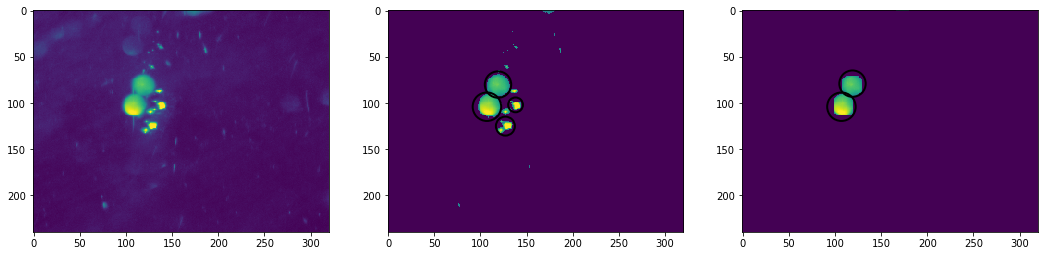

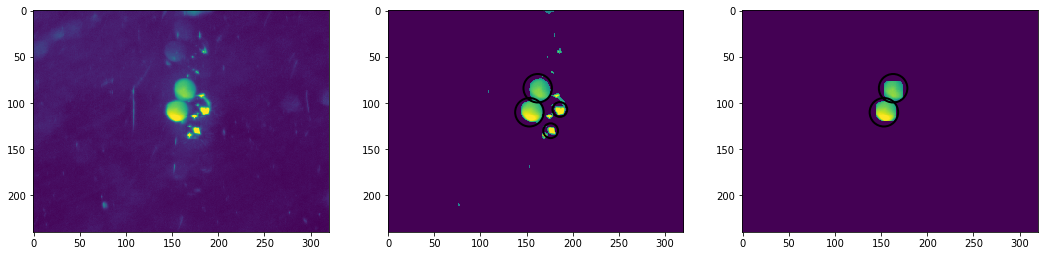

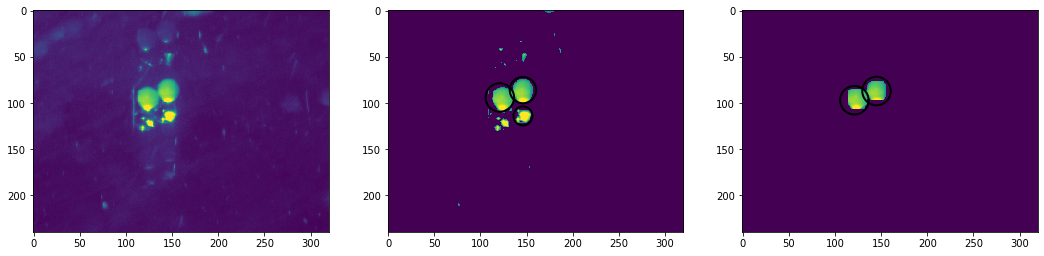

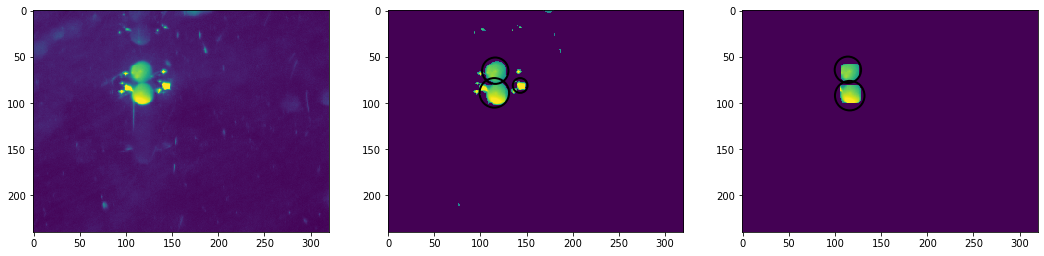

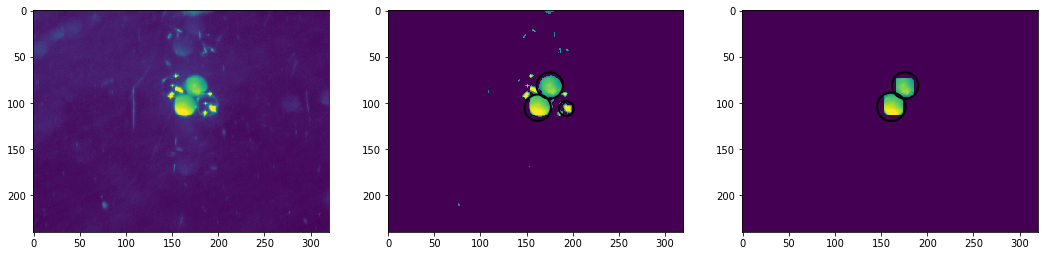

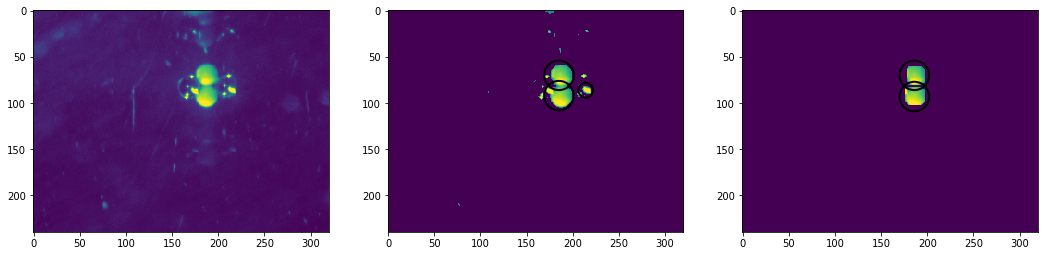

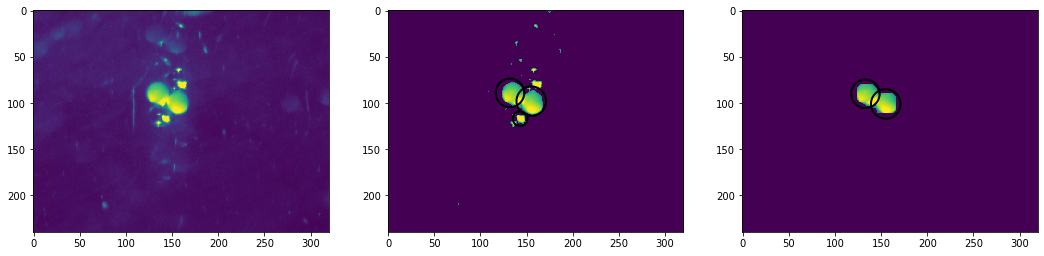

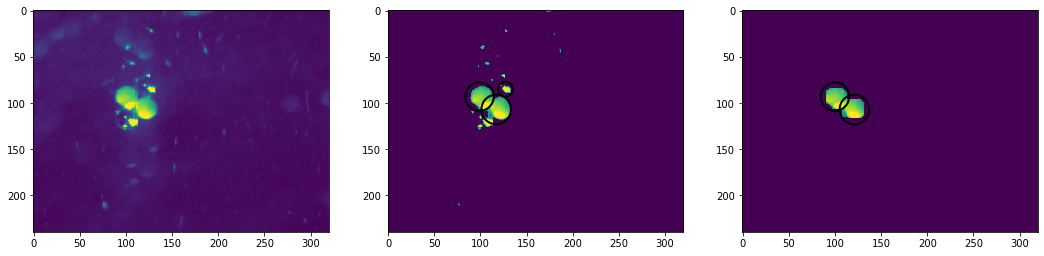

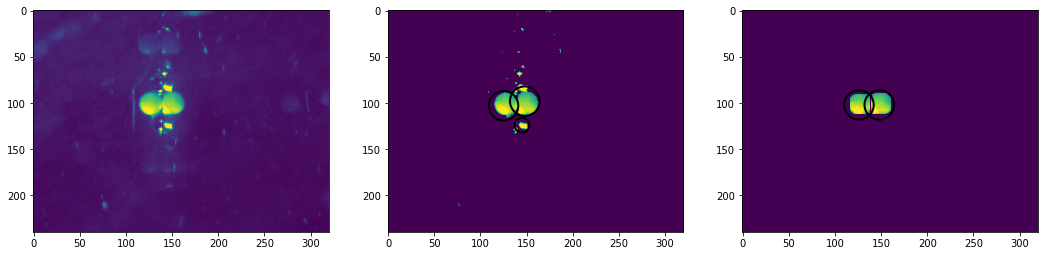

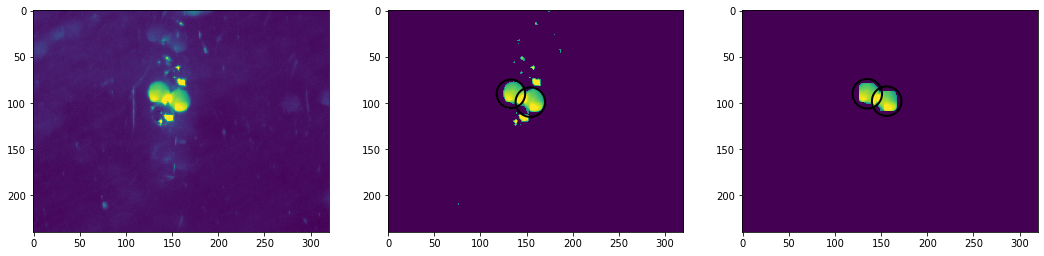

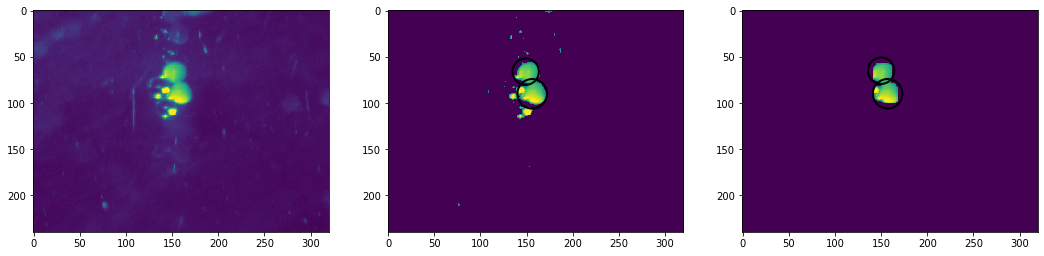

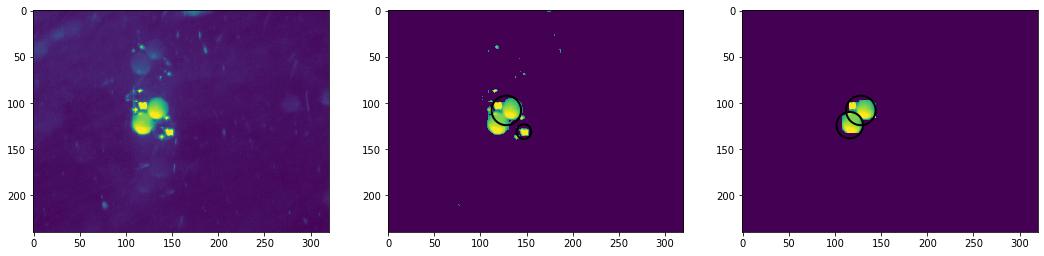

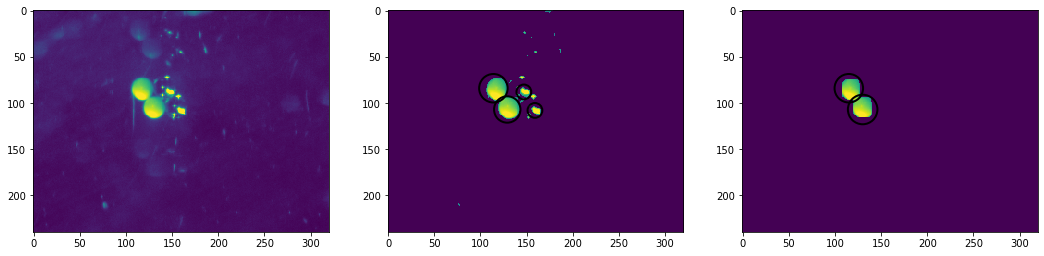

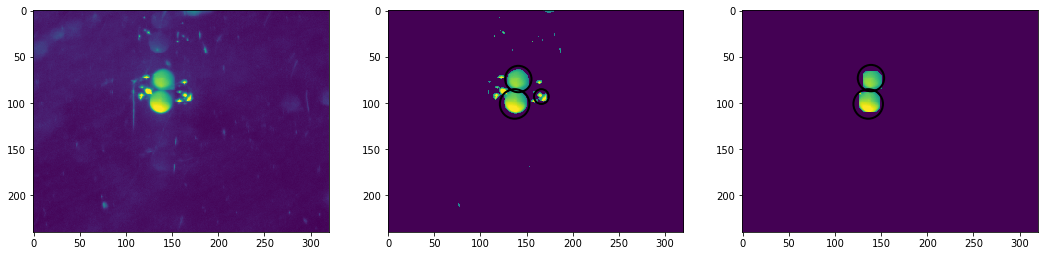

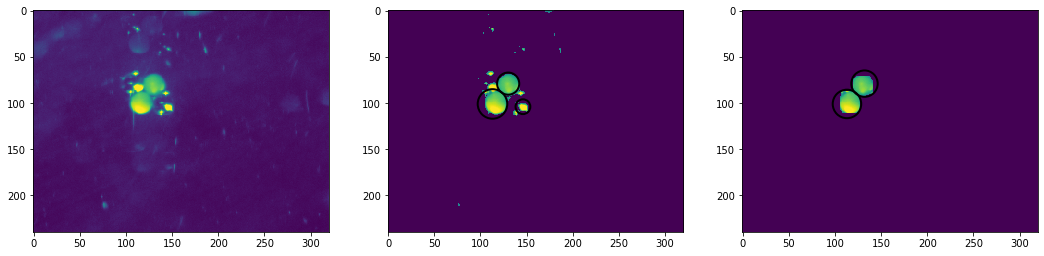

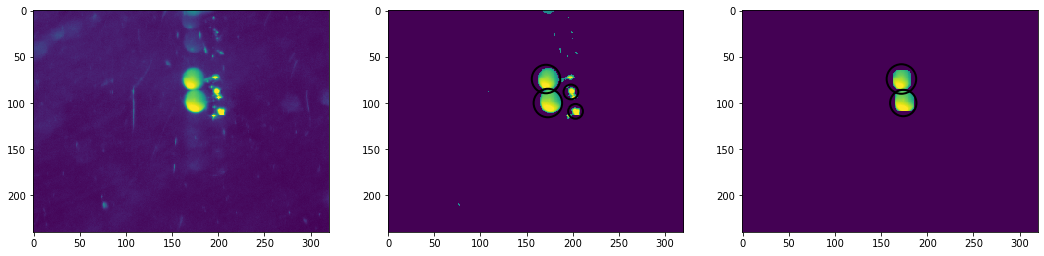

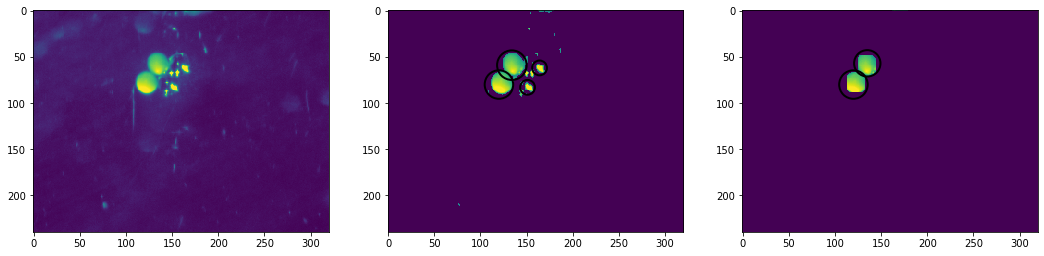

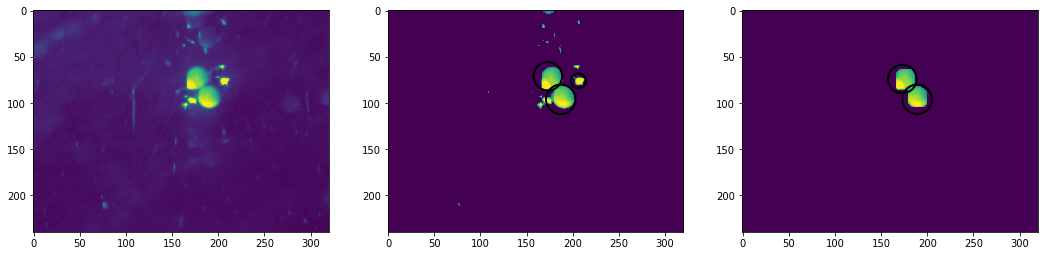

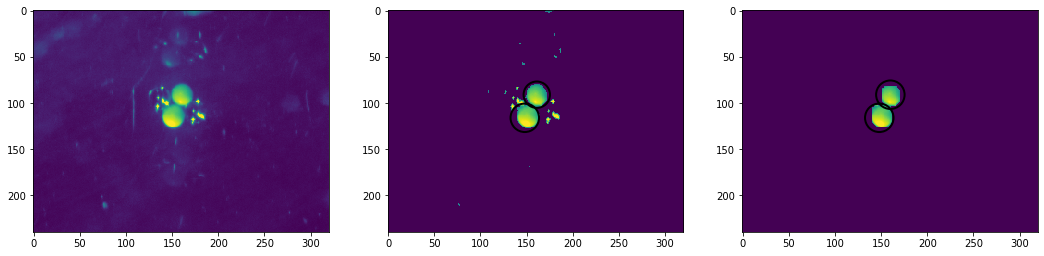

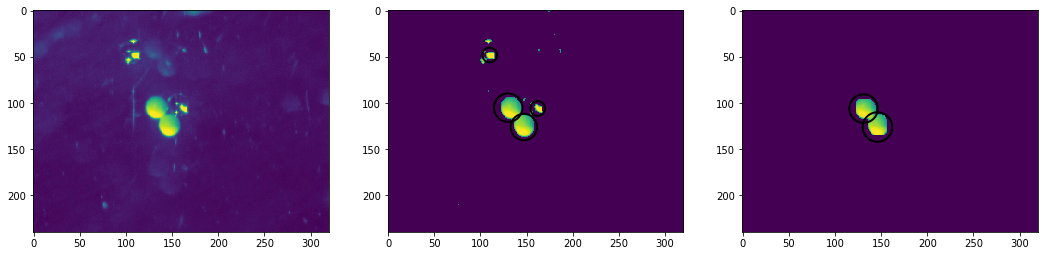

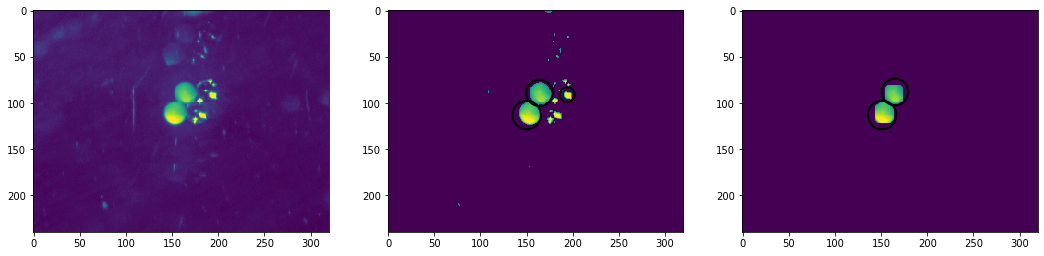

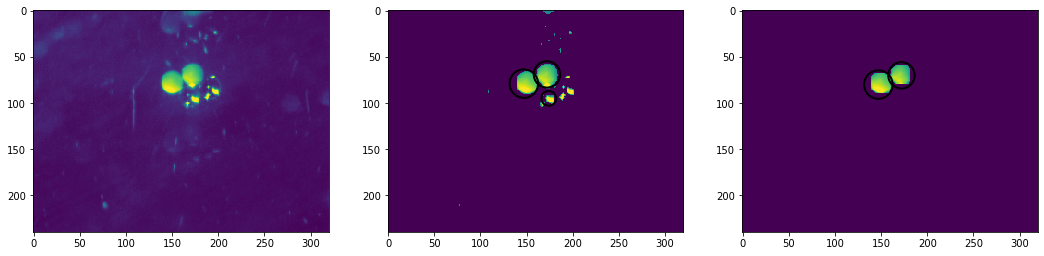

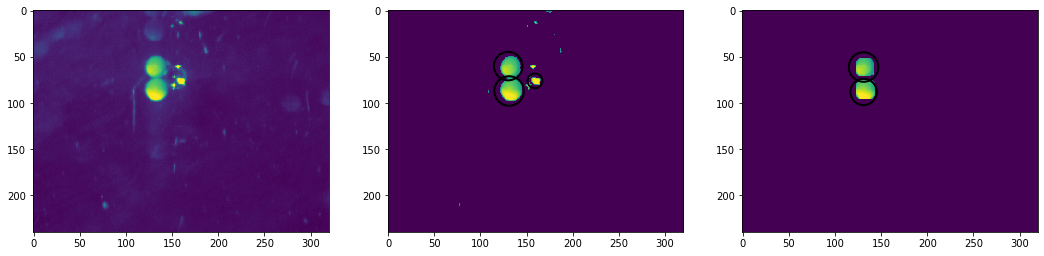

In [16]:
"""comparing filters"""
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import feature
from skimage.morphology import square

#a_props = opaque_threshold_properties(unfiltered)
#b_props = transparent_threshold_properties(unfiltered)
for i in range(0, len(framesets), int(len(framesets)/25)):
    highlight = unfiltered[i] > threshold_isodata(unfiltered[i])
    img = np.copy(unfiltered[i])
    img[highlight==0] = 0
    blobs = skimage.feature.blob_doh(img, min_sigma = 8, max_sigma = 16, threshold = 0.02, num_sigma=15 )
    
    highlight2 =morphology.opening(unfiltered[i] > threshold_isodata(unfiltered[i]), square(14))
    img2 = np.copy(unfiltered[i])
    img2[highlight2==0] = 0
    blobs2 =skimage.feature.blob_doh(img2, min_sigma = 8, max_sigma = 16, threshold = 0.02, num_sigma= 15, overlap=0.6)
    #np.concatenate((blobs, skimage.feature.blob_doh(img2, min_sigma = 11, max_sigma = 15, threshold = 0.008, num_sigma= 15)))
    
    fig, ax = plt.subplots(ncols = 3, figsize=(18, 8))
    ax[0].imshow(unfiltered[i])
    ax[1].imshow(img)
    for b in blobs:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        
        ax[1].add_patch(c)
    
    ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)

In [18]:
"""comparing filters"""
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import feature
from skimage.morphology import square, disk

#a_props = opaque_threshold_properties(unfiltered)
#b_props = transparent_threshold_properties(unfiltered)
for i in range(0, len(framesets), int(len(framesets)/20)):
    
    highlight2 =gaussian(
        morphology.opening(
             (unfiltered[i] > threshold_isodata(unfiltered[i])^morphology.opening(unfiltered[i] > threshold_isodata(unfiltered[i]), square(14)))
                           , disk(1)), sigma = 0.65)
    img2 = np.copy(unfiltered[i])
    img2[highlight2==0] = 0
    blobs2 =skimage.feature.blob_dog(img2, min_sigma =9, max_sigma = 16, threshold = 0.005,overlap=0.2)
    blobs2[:, 2] = blobs2[:, 2] * np.sqrt(2)
    #np.concatenate((blobs, skimage.feature.blob_doh(img2, min_sigma = 11, max_sigma = 15, threshold = 0.008, num_sigma= 15)))
    
    fig, ax = plt.subplots(ncols = 3, figsize=(18, 8))
    ax[0].imshow(unfiltered[i])
    highlight2[highlight2 != 0]=1
    ax[1].imshow(highlight2, cmap='jet')
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        
        ax[1].add_patch(c)
    
    """ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)"""
    ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)

TypeError: blob_dog() got an unexpected keyword argument 'num_sigma'

In [14]:
"""comparing filters"""
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage import feature
from skimage.morphology import square, disk

#a_props = opaque_threshold_properties(unfiltered)
#b_props = transparent_threshold_properties(unfiltered)
for i in range(0, len(framesets), int(len(framesets)/20)):
    highlight = morphology.closing(unfiltered[i][0] > threshold_minimum(unfiltered[i][0]))
    img = morphology.area_closing(unfiltered[i][0], 2000)
    img[highlight==0] = 0
    blobs = skimage.feature.blob_doh(img, min_sigma = 12, max_sigma = 16, threshold = 0.007, num_sigma=15 )
    
    highlight2 =img>28
    img2 = np.copy(unfiltered[i][0])
    img2[highlight2==0] = 0
    blobs2 =skimage.feature.blob_doh(img2, min_sigma = 8, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.5)
    #np.concatenate((blobs, skimage.feature.blob_doh(img2, min_sigma = 11, max_sigma = 15, threshold = 0.008, num_sigma= 15)))
    
    fig, ax = plt.subplots(ncols = 3, figsize=(18, 8))
    ax[0].imshow(unfiltered[i][0])
    ax[1].imshow(img)
    for b in blobs:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        
        ax[1].add_patch(c)
    
    ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)

ValueError: The parameter `image` must be a 2-dimensional array

In [ ]:
"""comparing filters"""
from skimage.filters import gaussian, sobel, scharr
from skimage.segmentation import active_contour
from skimage import feature
from skimage.feature import canny
from skimage.morphology import square, disk, watershed
from skimage.exposure import histogram, equalize_hist
from scipy import ndimage as ndi
from skimage.color import label2rgb
areas = []
#a_props = opaque_threshold_properties(unfiltered)
#b_props = transparent_threshold_properties(unfiltered)
for i in range(0, len(framesets), int(len(framesets)/23)):
    #highlight = morphology.closing(unfiltered[i][0] > 30, disk(3))
    #img = exposure.morphology.area_closing(unfiltered[i][0], 2000)
    
    img = scharr(unfiltered[i][0])
    blobs = skimage.feature.blob_doh(img, min_sigma = 12, max_sigma = 16, threshold = 0.007, num_sigma=15 )
    markers = np.zeros_like(unfiltered[i][0])
    markers[unfiltered[i][0] < threshold_mean(unfiltered[i][0])] = 1
    markers[unfiltered[i][0] > threshold_triangle(unfiltered[i][0])+2] = 2
    
    img2 = markers
    blobs2 =skimage.feature.blob_doh(img2, min_sigma = 8, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.5)
    #np.concatenate((blobs, skimage.feature.blob_doh(img2, min_sigma = 11, max_sigma = 15, threshold = 0.008, num_sigma= 15)))
    segmentation = morphology.watershed(img, img2)
    hist1, hist_centers1 = histogram(unfiltered[i][0])
    #img2 = segmentation
    segmentation = morphology.opening(ndi.binary_fill_holes(segmentation - 1), disk(3))
    labeled_balls, _ = ndi.label(segmentation)
    img_label_overlay = label2rgb(labeled_balls, image=unfiltered[i][0])
    #print(labeled_balls)

    fig, ax = plt.subplots(ncols = 4, figsize=(18, 8))
    ax[0].imshow(unfiltered[i][0])
    ax[1].imshow(img)
    for b in blobs:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        
        ax[1].add_patch(c)
    
    ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)
        
    ax[3].imshow(img_label_overlay)
    
    props = measure.regionprops(labeled_balls)
    biggest_r = props[0] 
    for region in props:
        if region.area > biggest_r.area:
            biggest_r = region
        else:
            pass
    area = biggest_r.area
    areas.append(area)
fig, ax = plt.subplots()
print(areas)
plt.hist(areas)

In [ ]:
"""comparing filters"""
from skimage.filters import gaussian, sobel, scharr
from skimage.segmentation import active_contour
from skimage import feature
from skimage.feature import canny
from skimage.morphology import square, disk, watershed
from skimage.exposure import histogram, equalize_hist
from scipy import ndimage as ndi
from skimage.color import label2rgb

areas = []
#a_props = opaque_threshold_properties(unfiltered)
#b_props = transparent_threshold_properties(unfiltered)
for i in range(0, len(framesets), int(len(framesets)/20)):
    #highlight = morphology.closing(unfiltered[i][0] > 30, disk(3))
    #img = exposure.morphology.area_closing(unfiltered[i][0], 2000)
    im = np.copy(unfiltered[i][0])
    highs = im > threshold_minimum(im)
    
    highs= morphology.opening(highs, disk(8))
    im[highs==0]=0
    img = scharr(im)
    blobs = skimage.feature.blob_doh(img, min_sigma = 12, max_sigma = 16, threshold = 0.007, num_sigma=15 )
    markers = np.zeros_like(unfiltered[i][0])
    markers[im < threshold_mean(unfiltered[i][0])] = 1
    markers[im > threshold_minimum(unfiltered[i][0])+2] = 2
    
    img2 = markers
    blobs2 =skimage.feature.blob_doh(img2, min_sigma = 8, max_sigma = 16, threshold = 0.007, num_sigma= 15, overlap=0.5)
    #np.concatenate((blobs, skimage.feature.blob_doh(img2, min_sigma = 11, max_sigma = 15, threshold = 0.008, num_sigma= 15)))
    segmentation = morphology.watershed(im, img2)
    hist1, hist_centers1 = histogram(unfiltered[i][0])
    #img2 = segmentation
    segmentation = ndi.binary_fill_holes(morphology.closing(segmentation - 1, disk(5)))
    labeled_balls, _ = ndi.label(segmentation)
    img_label_overlay = label2rgb(labeled_balls, image=unfiltered[i][0])


    fig, ax = plt.subplots(ncols = 4, figsize=(18, 8))
    ax[0].imshow(unfiltered[i][0])
    ax[1].imshow(im)
    for b in blobs:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        
        ax[1].add_patch(c)
    
    ax[2].imshow(img2)
    for b in blobs2:
        c = plt.Circle((b[1],b[0]), b[2], linewidth=2, fill=False)
        ax[2].add_patch(c)
        
    ax[3].imshow(img_label_overlay)
    props = measure.regionprops(labeled_balls)
    biggest_r = props[0] 
    for region in props:
        if region.area > biggest_r.area:
            biggest_r = region
        else:
            pass
    area = biggest_r.area
    areas.append(area)
fig, ax = plt.subplots()
print(areas)
plt.hist(areas)